In [1]:
from deepforest import utilities
import rasterio as rio
import os 
import glob
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch.optim as optim
import time
import numpy as np
from sklearn.model_selection import train_test_split
import random
import ast
from comet_ml import Experiment

import dataloading as dl


In [2]:
device = torch.device('cpu')

In [3]:
image_dir = 'C:/Users/zhou.m/Documents/2023_Fall/NeonTree/weecology/evaluation/RGB'

In [4]:
# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn()

# Modify the classification head for the number of classes in your dataset
num_classes = 2 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)

model.load_state_dict(torch.load('trained_model_1000.pth'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
filtered_df = pd.read_csv('annotations_filtered.csv', index_col = 0)
filtered_df

# Get unique image paths
unique_image_paths = filtered_df.index

# Split the unique image paths into training and testing sets
train_image_paths, test_image_paths = train_test_split(unique_image_paths, test_size=0.2, random_state=42)

# Filter the DataFrame based on the selected image paths for training and testing
train_df = filtered_df.loc[train_image_paths]
test_df = filtered_df.loc[test_image_paths]



In [6]:
transform = Compose([ToTensor()])
train_dataset = dl.TreeBoundingBoxes(train_df, image_dir, transform)
test_dataset = dl.TreeBoundingBoxes(test_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

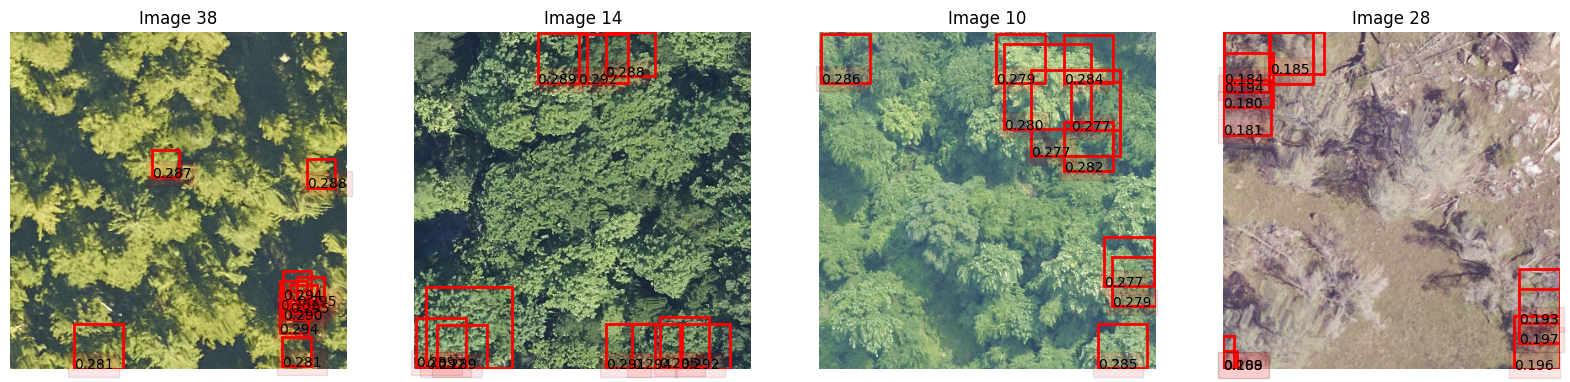

In [8]:
# Set the number of images to plot
num_images_to_plot = 4

# Get 4 random indices for the images in the testing set
random_indices = random.sample(range(len(test_dataset)), num_images_to_plot)

# Create a subplot with the desired number of images
fig, axs = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

for i, index in enumerate(random_indices):
    img, _ = test_dataset[index]
    img = img.permute((1, 0, 2)).to(device)

    # Perform inference
    with torch.no_grad():
        prediction = model(img.unsqueeze(0).to(device))[0]

    # Extract 'scores' values and filter based on the threshold
    scores = prediction.get('scores', []).cpu().numpy()
    boxes = prediction.get('boxes', []).cpu().numpy()
    labels = prediction.get('labels', []).cpu().numpy()

    # Assuming you're using the same threshold calculation as before
    threshold = np.median(scores[0:20])

    filtered_scores = [score for score in scores if score > threshold]
    filtered_boxes = [boxes[i] for i in range(len(scores)) if scores[i] > threshold]
    filtered_labels = [labels[i] for i in range(len(scores)) if scores[i] > threshold]

    # Display the testing image with predicted bounding boxes
    axs[i].imshow(img.permute(1, 2, 0))

    # Draw bounding boxes on the image
    for j in range(len(filtered_boxes)):
        box = filtered_boxes[j]
        label = filtered_labels[j]
        score = f'{filtered_scores[j]:.3f}'
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r',
                                 facecolor='none')
        axs[i].add_patch(rect)
        axs[i].text(box[0], box[3], f'{score}', bbox=dict(facecolor='red', alpha=0.1))

    axs[i].axis('off')
    axs[i].set_title('Image ' + str(index))

plt.show()
